In [1]:
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer,AdagradOptimizer
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
from autoencoder import Autoencoder
import warnings
warnings.filterwarnings("ignore")
import os 



In [1]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
import os
from EMCost import *


class Autoencoder_autodecoder():
   

    def __init__(self,n_qubit_autoencoder,n_qubit_trash,device,stages=['c6','c11'],seed=None):


        if seed is None:
            seed=random.random()
            self.__seed=seed
        else:
            self.__seed=seed
        random.seed(seed)
        if n_qubit_autoencoder not in [4,8]:
            raise Exception('either 4 or 8 qubit with this state prep')

        self.__layers=1
        self.__n_qubit_auto = n_qubit_autoencoder
        self.__n_qubit_trash = n_qubit_trash
        self.__n_qubit=n_qubit_autoencoder+n_qubit_trash
        self.__dvc=device
        self.__stages = stages
        self.__setup()

        self.__num_params= sum([self.__circuits[cir]['n_par'](n_qubit_autoencoder) for cir in stages])
        self.__num_params_stages= [self.__circuits[cir]['n_par'](n_qubit_autoencoder) for cir in stages]
        self.__set_weights =None
        
        #set parameter to random values for the first stage and 0 to all the following
        self.__wq=[np.array([random.uniform(0, np.pi) for _ in range(self.__num_params_stages[0])]+[0]*(self.__num_params-self.__num_params_stages[0]), requires_grad=True)]
        # print(f'the device has {len(device.wires)} qubits')
    

    def original_auto(self,qb,parameter,start):
        for i in range(start,qb+start):
            qml.RX(parameter[i-start],wires=i)
        for i in range(start,qb+start):
            qml.RZ(parameter[i-start +qb],wires=i)
        pindex=0
        for j in range(start,qb+start):
            for i in range(start,qb+start):
                if j != i:
                    qml.CRX(parameter[pindex +2*qb],wires=[j,i])
                    pindex-=-1
        for i in range(start,qb+start):
            qml.RX(parameter[i-start+2*qb+qb*(qb-1)],wires=i)
        for i in range(start,qb+start):
            qml.RZ(parameter[i-start+3*qb+qb*(qb-1)],wires=i)

    def __setup(self):
        self.__circuits = {
            'c6' : {'func':self.c6ansatz,
                    'n_par':lambda q: q**2 +3*q,
            },
            'c11' :{'func':self.c11ansatz,
                    'n_par':lambda q: (q*4 -4)*self.__layers,
            },
            'isin' : {'func':self.create_ising_state,
            'n_par': lambda q : 0
            }
        }
        self.__losses={
            'fidelity': {'func':self.fidelity},
            'EMdistance': {'func': cost_fn_EM}

        }
        self.__train_loss={}
        self.__val_loss= {}
        self.__sp = self.__circuits['isin']['func']

        self.__loss= self.__losses['EMdistance']['func']
        system_size_x = 1
        system_size_y = self.__n_qubit_auto
        system_lattice = "chain"
        system_periodicity = "closed"

        n_wires =self.__n_qubit_auto

        class dset:
            sysname = None
            xlen = 0
            ylen = 0
            tuning_parameter_name = None
            order_parameter_name = None
            lattice = None
            periodicity = None
            tuning_parameters = []

        Ising_dataset = dset()
        Ising_dataset.sysname = "Ising"
        Ising_dataset.xlen = system_size_x
        Ising_dataset.ylen = system_size_y
        Ising_dataset.lattice = system_lattice
        Ising_dataset.periodicity = system_periodicity
        Ising_dataset.tuning_parameter_name = "h"
        Ising_dataset.order_parameter_name = "mz"
        current_dataset = Ising_dataset

        self.__data = qml.data.load("qspin", 
                            sysname=current_dataset.sysname, 
                            periodicity=current_dataset.periodicity, 
                            lattice=current_dataset.lattice, 
                            layout=(current_dataset.xlen, current_dataset.ylen))[0]

        current_dataset.tuning_parameters = self.__data.parameters

    def get_input_state(self,p):
        @qml.qnode(self.__dvc)
        def _input_state():
            self.__sp(p,0)
            return qml.state()
        return _input_state()

    def fidelity(self,X,trainer,input_state):
        def _fidelity(w):
            output_dms =np.array([trainer(w,x) for x in X], requires_grad=True)
            fid=[1-qml.math.fidelity(a,b) for a,b in zip(output_dms,input_state)]
            return np.mean(np.array(fid))
        return _fidelity

    def create_ising_state(self,p,start):
        dm1 = np.matmul( np.matrix(np.conjugate(self.__data.ground_states[p])).T, np.matrix(self.__data.ground_states[p]) )
        qml.QubitDensityMatrix(dm1, wires=range(self.__n_qubit_auto))

    

    def c6ansatz(self,param,start=0):
        self.original_auto(self.__n_qubit_auto,param,start=start)

    def create_circ(self,param,p,start=0):
        self.__sp(p,0)
        qml.Barrier()
        self.create_encoder(param,start)
        qml.Barrier()
        self.create_decoder(param,start)


    def create_encoder(self,params,start=0):
        for stage,a in enumerate(self.__stages):
            stage_params = (sum([self.__circuits[self.__stages[a]]['n_par'](self.__n_qubit_auto) for a in range(stage)]),sum([self.__circuits[self.__stages[a]]['n_par'](self.__n_qubit_auto) for a in range(stage+1)]))

            self.__circuits[a]['func'](params[stage_params[0]:stage_params[1]],start)
            
    def create_decoder(self,params,start=0):
        wire_map=dict(zip(list(range(self.__n_qubit_trash)),list(range(self.__n_qubit_auto,self.__n_qubit))))

        def f():
            for stage,a in enumerate(self.__stages):
                stage_params = (sum([self.__circuits[self.__stages[a]]['n_par'](self.__n_qubit_auto) for a in range(stage)]),sum([self.__circuits[self.__stages[a]]['n_par'](self.__n_qubit_auto) for a in range(stage+1)]))
                self.__circuits[a]['func'](params[stage_params[0]:stage_params[1]],start)
        qml.adjoint(qml.map_wires(f, wire_map))()


    def set_layers(self,layers):
        self.__layers = layers
        self.__num_params=sum([self.__circuits[cir]['n_par'](self.__n_qubit_auto) for cir in self.__stages])
        self.__num_params_stages= [self.__circuits[cir]['n_par'](self.__n_qubit_auto) for cir in self.__stages]
        random.seed(self.__seed)
        self.__wq=[np.array([random.uniform(0, np.pi) for _ in range(self.__num_params_stages[0])]+[0]*(self.__num_params-self.__num_params_stages[0]), requires_grad=True)]

    def c11(self,parameter,qb,start):
        current_par =0
        for i in range(start,qb//2+start):
            qml.RY(parameter[current_par],wires=(i-start)*2+start)
            current_par-=-1
            qml.RY(parameter[current_par],wires=(i-start)*2+start+1)
            current_par-=-1

        for i in range(start,qb//2+start):
            qml.RZ(parameter[current_par],wires=(i-start)*2+start)
            current_par-=-1
            qml.RZ(parameter[current_par],wires=(i-start)*2+start+1)
            current_par-=-1

        for i in range(start,qb//2+start):
            qml.CNOT([(i-start)*2+start+1,(i-start)*2+start])

        qml.Barrier()
        for i in range(start,(qb-1)//2+start):        
            qml.RY(parameter[current_par],wires=(i-start)*2+start+1)
            current_par-=-1
            qml.RY(parameter[current_par],wires=(i-start)*2+start+2)
            current_par-=-1

        for i in range(start,(qb-1)//2+start):   
            qml.RZ(parameter[current_par],wires=(i-start)*2+start+1)
            current_par-=-1
            qml.RZ(parameter[current_par],wires=(i-start)*2+start+2)
            current_par-=-1


        for i in range(start,(qb-1)//2+start):
            qml.CNOT([(i-start)*2+start+2,(i-start)*2+start+1])
        qml.Barrier()

    def c11ansatz(self,param,start):
        parperlay = 4*self.__n_qubit_auto-4
        for l in range(self.__layers):
            self.c11(param[parperlay*l:parperlay*(l+1)],self.__n_qubit_auto,start) 
            qml.Barrier()

    def plot_cirq(self):

        @qml.qnode(self.__dvc)
        def trainer(param,p):
            self.create_circ(param,p)
        fig, ax = qml.draw_mpl(trainer)(self.__wq[-1],.5)
        plt.show()

    def train(self, X , opt,epochs,batch_size=None,warm_weights=None, val_split=0.0):
        train_loss = []   
        val_loss = [0]

        X_train = X[0:int(np.floor(len(X)*(1-val_split)))]
        X_val = X[int(np.floor(len(X)*(1-val_split))):]
        if batch_size is None:
            batch_size=len(X)
        if warm_weights is not None:
            if len(warm_weights)!= self.__num_params:
                raise ValueError(f'The weights for the warm start should have length {self.__num_params}, but {len(warm_weights)} where found.')
            self.__wq[-1]=warm_weights
        if type(epochs) == int:
            epochs = [epochs]+[0]*(len(self.__stages)-1)
        if len(epochs)>len(self.__stages):
            raise ValueError(f'The number of stage epochs are more than the number of stages')
        @qml.qnode(self.__dvc,diff_method='best')
        def trainer(param,p):
            self.create_circ(param,p)
            return qml.state()
        
        for stage,stage_epoch in enumerate(epochs):
            stage_params = (sum([self.__circuits[self.__stages[a]]['n_par'](self.__n_qubit_auto) for a in range(stage)]),sum([self.__circuits[self.__stages[a]]['n_par'](self.__n_qubit_auto) for a in range(stage+1)]))
            opt.reset()
            for epoch in range(stage_epoch):
                batch_loss=[]
                for i, X_batch in enumerate([X_train[i:i + batch_size] for i in range(0, len(X_train), batch_size)]):

                    loss_function = self.__loss(X_batch,trainer,[self.get_input_state(x) for x in X_batch])
                    weights, loss_value = opt.step_and_cost(loss_function, self.__wq[-1][stage_params[0]:stage_params[1]])
                    batch_loss.append(loss_value)
                    print(f'\rStage: {stage}, \tEpoch {epoch+1}, \tBatch:{i}, \tTrain Loss = {np.mean(batch_loss):.6f}, \tVal Loss = {val_loss[-1]:.6f}',end='')
               
                self.__wq.append(np.concatenate([self.__wq[-1][:stage_params[0]], weights, [0]*(self.__num_params-stage_params[1])], axis=0))

                val_l=self.__loss(X_val,trainer,[self.get_input_state(x) for x in X_val]) 
                val_loss.append(val_l(self.__wq[-1]))
                train_loss.append(np.average(batch_loss,weights=[len(X_batch) for X_batch in [X_train[i:i + batch_size] for i in range(0, len(X_train), batch_size)]]))

                if epoch > 5 and np.mean(val_loss[-3:])<0.001:
                    print('\nEarly stop')
                    break

        try:
            console_size = os.get_terminal_size()
        except OSError:
            console_size = 50
        print('\n')
        print('-'*console_size)
        self.__train_loss=train_loss
        self.__val_loss=val_loss[1:]
        return train_loss,val_loss[1:], self.__wq.copy()

    def best_params(self):
        return self.__wq[np.argmin(self.__val_loss)+1] 

    def get_cirq(self,wire):
        if self.__set_weights is None:
            self.create_encoder(self.best_params(),wire)
        else:
            self.create_encoder(self.__set_weights,wire)
    
    def plot_loss(self):
        custom_palette =['#EABFCB','#C191A1','#A4508B','#5F0A87','#2F004F','#120021',]
        sns.set_palette(custom_palette)  

        plt.set_cmap
        plt.plot(list(range(len(self.__train_loss))),self.__train_loss, label='train loss')
        plt.plot(list(range(len(self.__val_loss))),self.__val_loss, label='val loss')
        plt.legend()
        plt.show()
    def plot_weights(self):
        i=0
        for a in np.array(self.__wq).T:
            plt.plot(range(len(a)),a,label=[i])
            i-=-1
        plt.legend()

    def get_loss(self):
        return self.__train_loss,self.__val_loss
    
    def get_num_par(self):
        return self.__num_params
    
    def set_weights(self,param):
        self.__set_weights= param
    
    def load(self,path):
        self.__set_weights=np.load(path+'/weights.npy')
        self.__train_loss=np.load(path+'/train_loss.npy')
        self.__val_loss=np.load(path+'/val_loss.npy')

    def get_current_loss(self,X):
        @qml.qnode(self.__dvc,diff_method='adjoint')
        def trainer(param,p):
            self.create_circ(param,p)
            return qml.probs(list(range(self.__n_qubit_trash)))
        def loss_function():
            if self.__set_weights is not None:
                W=self.__set_weights
            else:
                W =self.__wq[-1]
            pred =np.array([1-trainer(W,x)[0] for x in X], requires_grad=True)
            current_loss = pred.mean()
            return current_loss
        return loss_function()


In [2]:
n_trash_qubit=2
n_qubit_autoencoder=4
n_qubit=n_qubit_autoencoder+n_trash_qubit
dvc = qml.device('default.mixed', wires=n_qubit, shots=None)

ae = Autoencoder_autodecoder(n_qubit_autoencoder,n_trash_qubit,dvc,stages=['c11'])


In [18]:
def trace_out(state,keep):
     #keep A list of components to keep after partial trace
     ob=qutip.Qobj(state,dims=[, [2, 2, 2, 2, 2, 2]])
     return np.array(ob.ptrace(keep).full(),requires_grad=True)

In [35]:
state = ae.get_input_state(2) 
ob=qutip.Qobj(state,dims=[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]])
np.array(ob.ptrace(range(4)).full(),requires_grad=True)

tensor([[ 4.99178111e-01+0.j, -1.01090596e-02+0.j, -1.01090596e-02+0.j,
          8.15559062e-04+0.j, -1.01090596e-02+0.j,  4.08112919e-04+0.j,
          8.15559062e-04+0.j, -1.01090596e-02+0.j, -1.01090596e-02+0.j,
          8.15559062e-04+0.j,  4.08112919e-04+0.j, -1.01090596e-02+0.j,
          8.15559062e-04+0.j, -1.01090596e-02+0.j, -1.01090596e-02+0.j,
          4.99178111e-01+0.j],
        [-1.01090596e-02+0.j,  2.04722691e-04+0.j,  2.04722691e-04+0.j,
         -1.65162194e-05+0.j,  2.04722691e-04+0.j, -8.26486126e-06+0.j,
         -1.65162194e-05+0.j,  2.04722691e-04+0.j,  2.04722691e-04+0.j,
         -1.65162194e-05+0.j, -8.26486126e-06+0.j,  2.04722691e-04+0.j,
         -1.65162194e-05+0.j,  2.04722691e-04+0.j,  2.04722691e-04+0.j,
         -1.01090596e-02+0.j],
        [-1.01090596e-02+0.j,  2.04722691e-04+0.j,  2.04722691e-04+0.j,
         -1.65162194e-05+0.j,  2.04722691e-04+0.j, -8.26486126e-06+0.j,
         -1.65162194e-05+0.j,  2.04722691e-04+0.j,  2.04722691e-04+0.j,
  

In [49]:
opt=AdamOptimizer(stepsize=.2)
X=list(range(100))
random.shuffle(X)
epochs=[37]

ae.train(X,opt,epochs,100,val_split=.33)


KeyError: 'num_input_qubits'

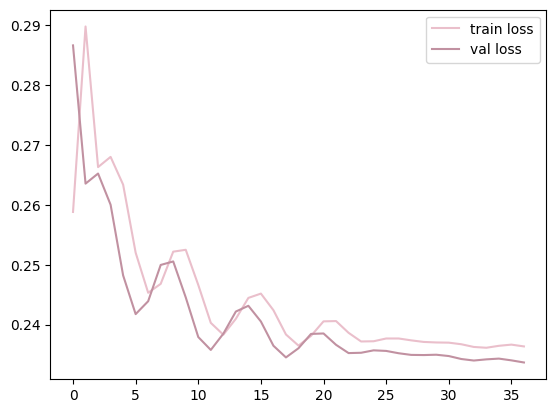

In [46]:
ae.plot_loss()